# TensorFlow Time Series Predictions

Play with the same data as linear regressions.

## Get Basic Setup Done

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import util

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

## Generate Test Data

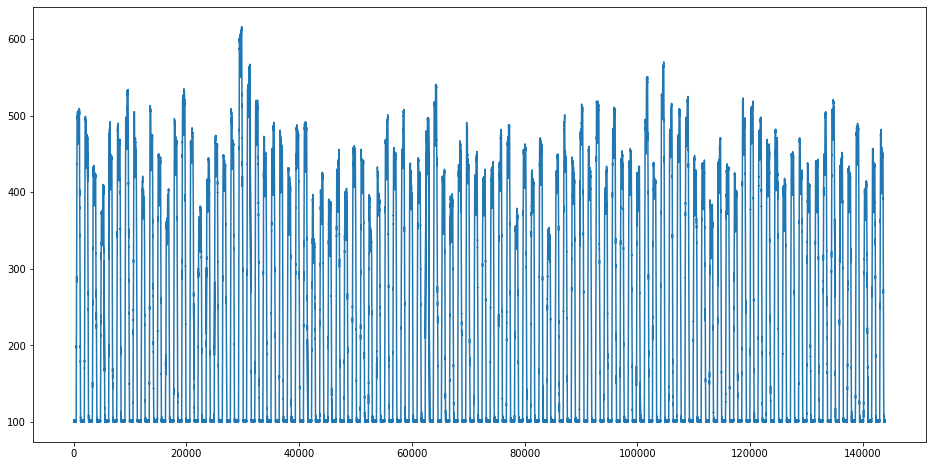

In [2]:
# Number of days to generate data for
DAYS = 100

# generate a numpy array of raw data first
d = util.gen_data(days=DAYS)

# turn it into a pandas data frame
df = pd.DataFrame({'Time': d[:, 0], 'ACEs': d[:, 1]})

# plot just the ACEs series
plt.plot(df['ACEs'])

## Univariate Data Extraction

This function takes in a 1D dataset of values (`dataset`) and carves it up into two different returns:

- An array of arrays of length `history_size` of overlapping data, starting with the data at `start_index`, ending at `end_index`.
- A simple array of future values that are `target_size` ticks in the future from each of the arrays above that are effectively the value we're trying to train to/for.

So, for setting `target_size`, consider how far into the future you want to predict, and for `history_size` consider how much of past history you want to consider.

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    '''
    * dataset the 1D array of data
    * start_index where in dataset to get data from
    * end_index last index to take data from
    * history_size size of past window of information
    * target_size how far in the future to predict
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d1f1710>],
      dtype=object)

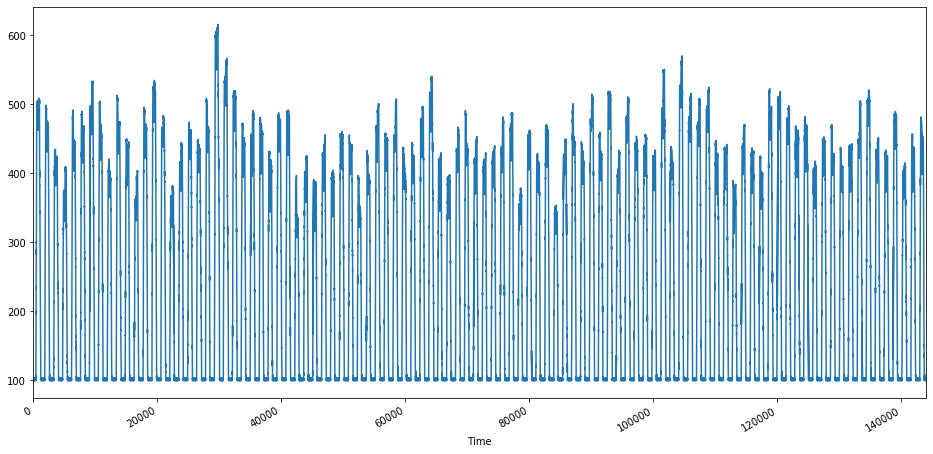

In [4]:
uni_data = df['ACEs']
uni_data.index = df['Time']
uni_data.plot(subplots=True)

## Normalize Data

Mean    = 242.88704166666668
Std Dev = 158.22005303367425


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d31f550>],
      dtype=object)

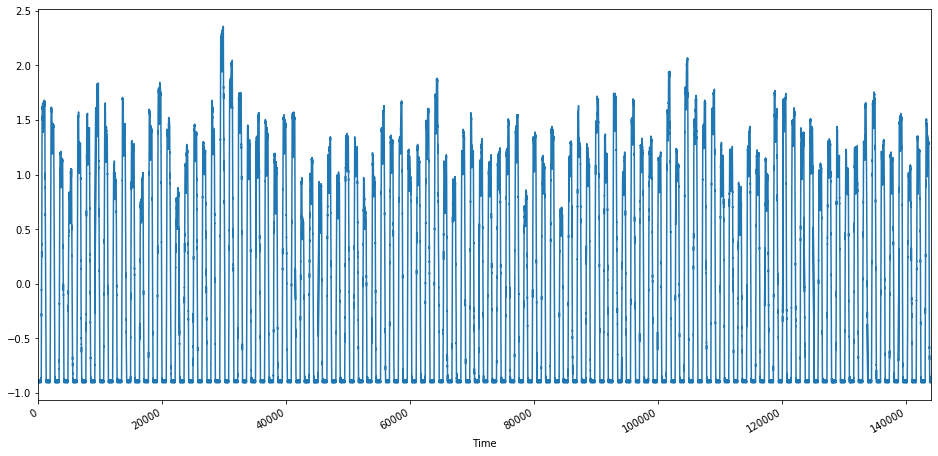

In [5]:
uni_train_mean = uni_data.mean()
uni_train_std = uni_data.std()

print('Mean    = {}'.format(uni_train_mean))
print('Std Dev = {}'.format(uni_train_std))

uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data.plot(subplots=True)

## Prepare Data

In [6]:
uni_data_vals = uni_data.values

# uses the past "day" for history (one tick is one minute)
# univariate_past_history = 1440

# try 30 minutes of history
univariate_past_history = 30

# predict 1 minute ahead
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data_vals, 0, 1440*(DAYS-2),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_vals, 1440*(DAYS-2), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [7]:
print(x_train_uni.shape)
print(x_train_uni)
print(y_train_uni.shape)
print(y_train_uni)

(141090, 30, 1)
[[[-0.90309059]
  [-0.89044997]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89677028]]

 [[-0.89044997]
  [-0.88412966]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.89677028]
  [-0.90309059]]

 [[-0.88412966]
  [-0.89044997]
  [-0.88412966]
  ...
  [-0.89677028]
  [-0.90309059]
  [-0.88412966]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]]
(141090,)
[-0.90309059 -0.88412966 -0.88412966 ... -0.90309059 -0.89044997
 -0.89677028]


In [8]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.90309059]
 [-0.89044997]
 [-0.88412966]
 [-0.89044997]
 [-0.88412966]
 [-0.89677028]
 [-0.89677028]
 [-0.90309059]
 [-0.90309059]
 [-0.89677028]
 [-0.89677028]
 [-0.90309059]
 [-0.90309059]
 [-0.89044997]
 [-0.89044997]
 [-0.90309059]
 [-0.90309059]
 [-0.88412966]
 [-0.90309059]
 [-0.90309059]
 [-0.88412966]
 [-0.90309059]
 [-0.90309059]
 [-0.90309059]
 [-0.89044997]
 [-0.90309059]
 [-0.90309059]
 [-0.90309059]
 [-0.90309059]
 [-0.89677028]]

 Target temperature to predict
-0.9030905939353704


In [9]:
def create_time_steps(length):
    return list(range(-length, 0))

In [10]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'gx', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

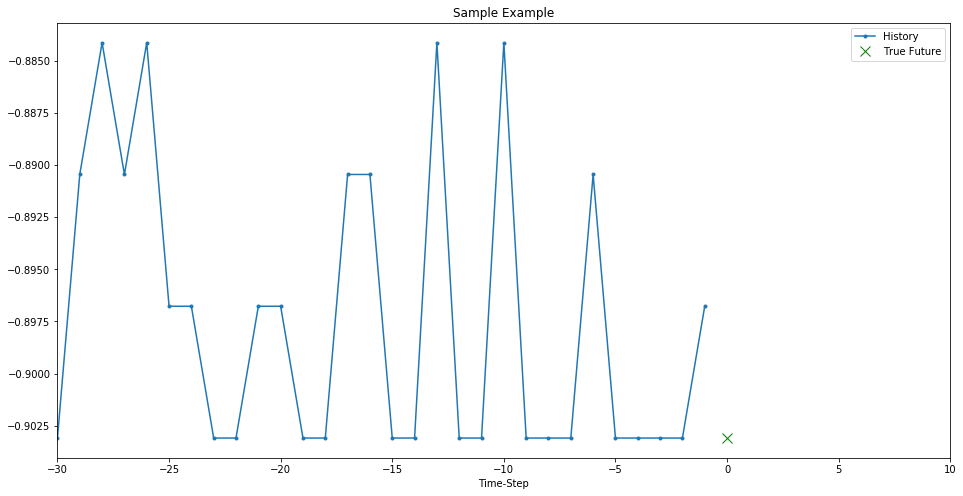

In [11]:
# for i in range(0, 1000, 100):

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

## Take Average of Last Day of Observations & Predict

In [12]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/einarnn/.virtualenvs/a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

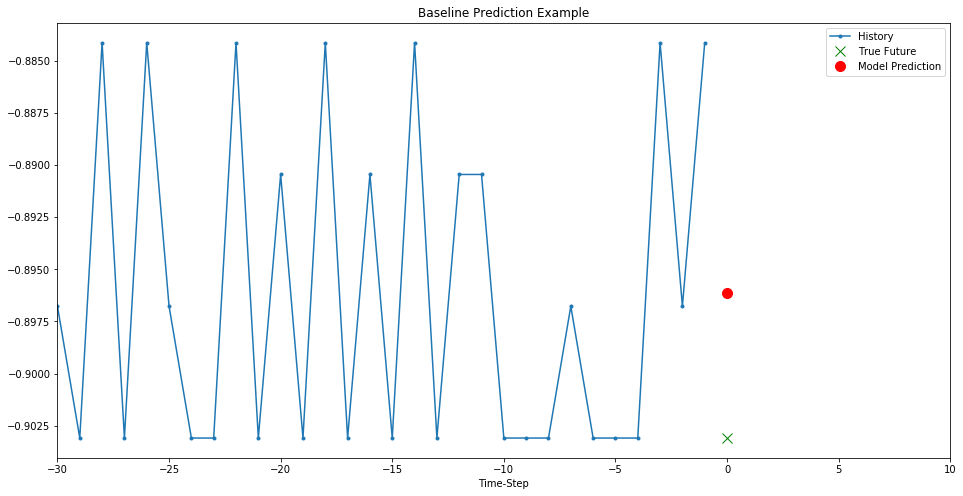

In [13]:
show_plot([x_train_uni[200], y_train_uni[200], baseline(x_train_uni[200])], 0, 'Baseline Prediction Example')

This is really not a very good prediction mechanism!!

## Recurrent Neural Network

In [14]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(141090, 30, 1)
(141090,)


### Batch Up The Data Into TF Data Structures

In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### Compile The Model

First, define a function to create and compile the model.

In [16]:
#
# single layer
#
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(15, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.Dense(1)
#])

BREADTH = 30

#
# create and compile a model
#
def create_model(breadth=BREADTH, input_shape=None):
    retval = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(BREADTH, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(BREADTH, return_sequences=True),
        tf.keras.layers.LSTM(BREADTH),
        tf.keras.layers.Dense(1)
    ])
    retval.compile(optimizer='adam', loss='mae')
    return retval    

Then create an actual instance:

In [17]:
simple_lstm_model = create_model(input_shape=x_train_uni.shape[-2:])

Take a look at what a prediuction will give you by taking one window from the validation set and calling `predict`:

In [18]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Now we can train the model if we want. But skip this if you just want to load pre-created weights:

In [19]:
EVALUATION_INTERVAL = 10   # original 200
VALIDATION_STEPS    = 50   # original 50
EPOCHS              = 50   # original 5

history_lstm = simple_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=VALIDATION_STEPS)

Train for 10 steps, validate for 50 steps
Epoch 1/50
10/10 [==============================] - 7s 705ms/step - loss: 0.8305 - val_loss: 0.5840
Epoch 2/50
10/10 [==============================] - 1s 123ms/step - loss: 0.3977 - val_loss: 0.1992
Epoch 3/50
10/10 [==============================] - 1s 135ms/step - loss: 0.1508 - val_loss: 0.1487
Epoch 4/50
10/10 [==============================] - 1s 137ms/step - loss: 0.1236 - val_loss: 0.0698
Epoch 5/50
10/10 [==============================] - 1s 132ms/step - loss: 0.1049 - val_loss: 0.0625
Epoch 6/50
10/10 [==============================] - 1s 124ms/step - loss: 0.0777 - val_loss: 0.0516
Epoch 7/50
10/10 [==============================] - 1s 133ms/step - loss: 0.0613 - val_loss: 0.0564
Epoch 8/50
10/10 [==============================] - 1s 120ms/step - loss: 0.0570 - val_loss: 0.0483
Epoch 9/50
10/10 [==============================] - 1s 129ms/step - loss: 0.0576 - val_loss: 0.0513
Epoch 10/50
10/10 [==============================] - 1s 12

Save the weights. Again, don't do this if we're loading a predefined set of weights.

In [20]:
simple_lstm_model.save_weights('save_lstm')

Load a predefined set of weights. Note that the model definition really needs top be the same, so look out for that,. noting that some weights files will load into a model that is not the same; seems to happen when you have more layers in the model you trained than you are loading into:

In [21]:
loaded_lstm_model = create_model(input_shape=x_train_uni.shape[-2:])
loaded_lstm_model.load_weights('save_lstm')

In [22]:
loaded_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


## Do Some Sample Predictions

This loop will display a plot per prediction.

[[[-0.89044997]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 [[-0.90309059]
  [-0.89677028]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.88412966]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 [[-0.89044997]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.90309059]]]
(30, 1)
()
[-0.8853829]


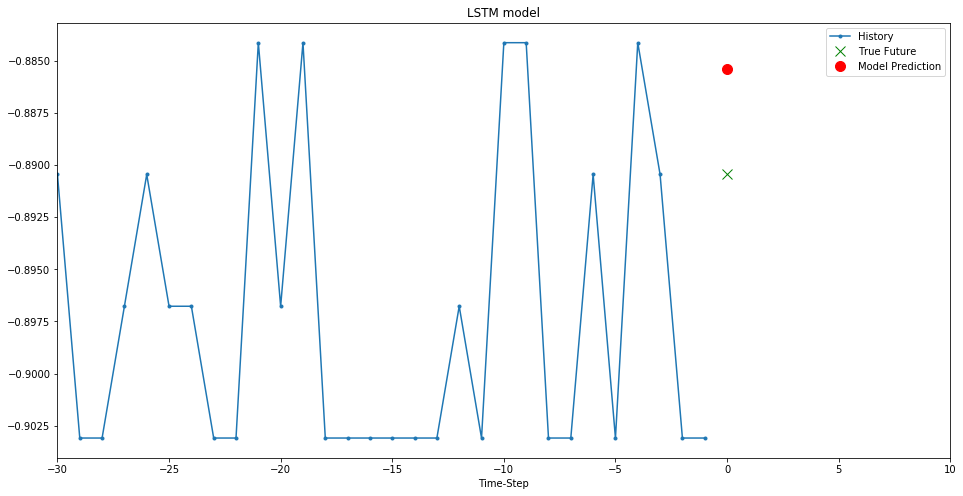

[[[-0.90309059]
  [-0.88412966]
  [-0.89677028]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.88412966]
  [-0.89677028]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89677028]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89677028]]

 ...

 [[-0.03088763]
  [-0.01192669]
  [ 0.01335455]
  ...
  [ 0.12712016]
  [ 0.15872172]
  [ 0.19032327]]

 [[-0.01192669]
  [ 0.01335455]
  [ 0.01335455]
  ...
  [ 0.15872172]
  [ 0.19032327]
  [ 0.2029639 ]]

 [[ 0.01335455]
  [ 0.01335455]
  [-0.01192669]
  ...
  [ 0.19032327]
  [ 0.2029639 ]
  [ 0.23456545]]]
(30, 1)
()
[-0.88803494]


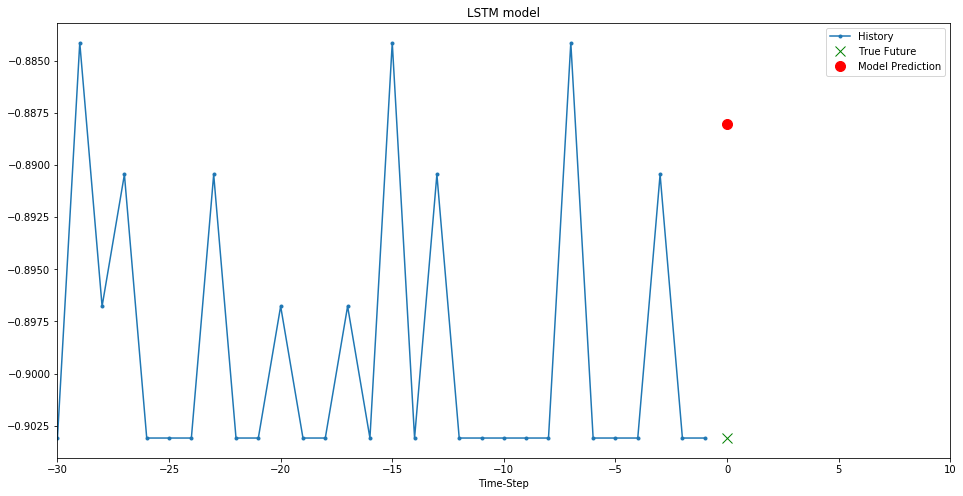

[[[ 0.01335455]
  [-0.01192669]
  [ 0.0386358 ]
  ...
  [ 0.2029639 ]
  [ 0.23456545]
  [ 0.29144825]]

 [[-0.01192669]
  [ 0.0386358 ]
  [ 0.0386358 ]
  ...
  [ 0.23456545]
  [ 0.29144825]
  [ 0.28512794]]

 [[ 0.0386358 ]
  [ 0.0386358 ]
  [ 0.06391705]
  ...
  [ 0.29144825]
  [ 0.28512794]
  [ 0.29144825]]

 ...

 [[ 0.9297997 ]
  [ 0.91715908]
  [ 0.91715908]
  ...
  [ 0.89187783]
  [ 0.91083877]
  [ 0.91715908]]

 [[ 0.91715908]
  [ 0.91715908]
  [ 0.91083877]
  ...
  [ 0.91083877]
  [ 0.91715908]
  [ 0.94244033]]

 [[ 0.91715908]
  [ 0.91083877]
  [ 0.90451846]
  ...
  [ 0.91715908]
  [ 0.94244033]
  [ 0.94244033]]]
(30, 1)
()
[0.22294238]


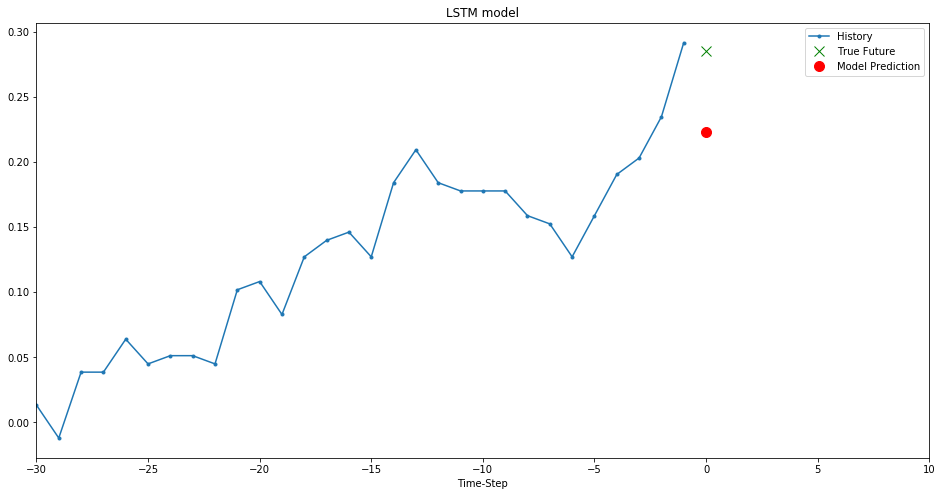

[[[0.91083877]
  [0.90451846]
  [0.90451846]
  ...
  [0.94244033]
  [0.94244033]
  [0.96140126]]

 [[0.90451846]
  [0.90451846]
  [0.90451846]
  ...
  [0.94244033]
  [0.96140126]
  [0.98668251]]

 [[0.90451846]
  [0.90451846]
  [0.90451846]
  ...
  [0.96140126]
  [0.98668251]
  [0.97404188]]

 ...

 [[1.22685434]
  [1.2078934 ]
  [1.16997154]
  ...
  [0.90451846]
  [0.91083877]
  [0.91083877]]

 [[1.2078934 ]
  [1.16997154]
  [1.16365122]
  ...
  [0.91083877]
  [0.91083877]
  [0.88555752]]

 [[1.16997154]
  [1.16365122]
  [1.16997154]
  ...
  [0.91083877]
  [0.88555752]
  [0.87923721]]]
(30, 1)
()
[0.9402013]


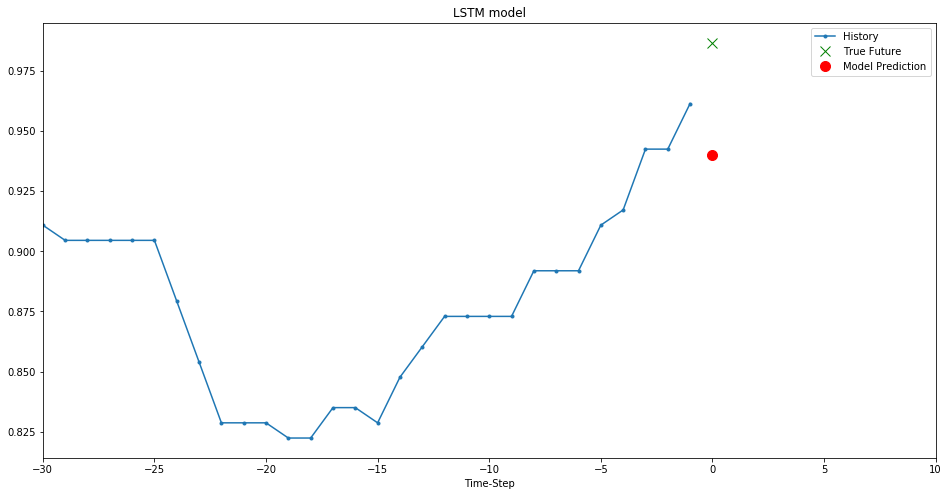

[[[ 1.16365122]
  [ 1.16997154]
  [ 1.16365122]
  ...
  [ 0.88555752]
  [ 0.87923721]
  [ 0.89819815]]

 [[ 1.16997154]
  [ 1.16365122]
  [ 1.13204967]
  ...
  [ 0.87923721]
  [ 0.89819815]
  [ 0.85395597]]

 [[ 1.16365122]
  [ 1.13204967]
  [ 1.13204967]
  ...
  [ 0.89819815]
  [ 0.85395597]
  [ 0.84131534]]

 ...

 [[-0.89044997]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89044997]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89044997]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]]
(30, 1)
()
[0.9325729]


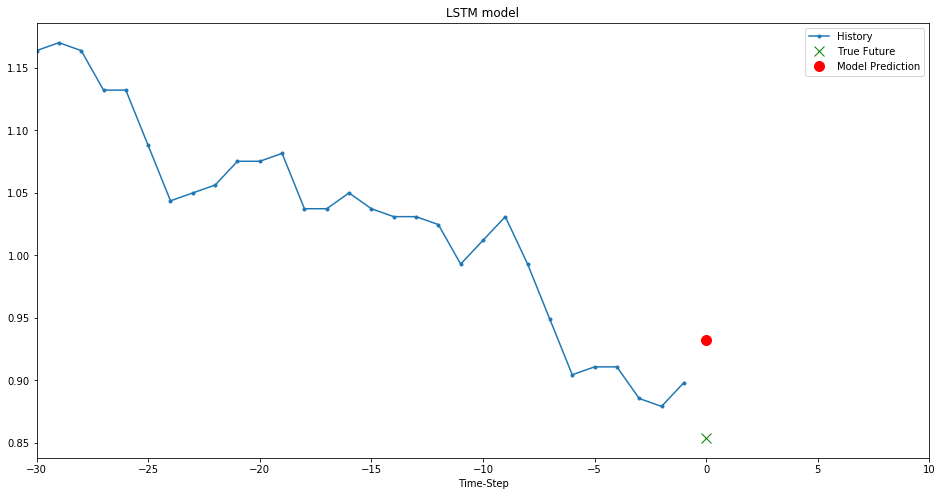

[[[-0.88412966]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.88412966]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.89677028]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.89677028]
  [-0.90309059]
  [-0.89044997]]

 [[-0.90309059]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.90309059]]]
(30, 1)
()
[-0.8893305]


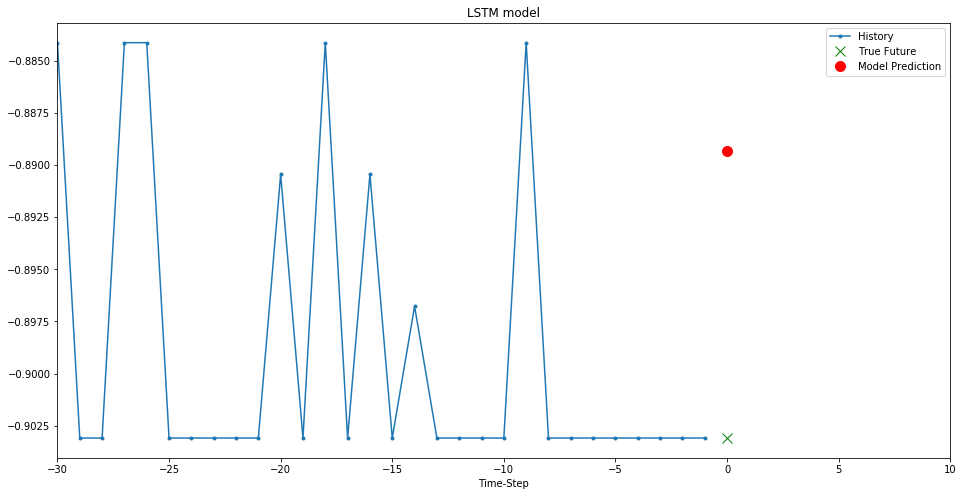

[[[-0.88412966]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89677028]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89677028]
  [-0.89677028]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 ...

 [[-0.88412966]
  [-0.89044997]
  [-0.89677028]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89044997]
  [-0.89677028]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89677028]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]]
(30, 1)
()
[-0.8864809]


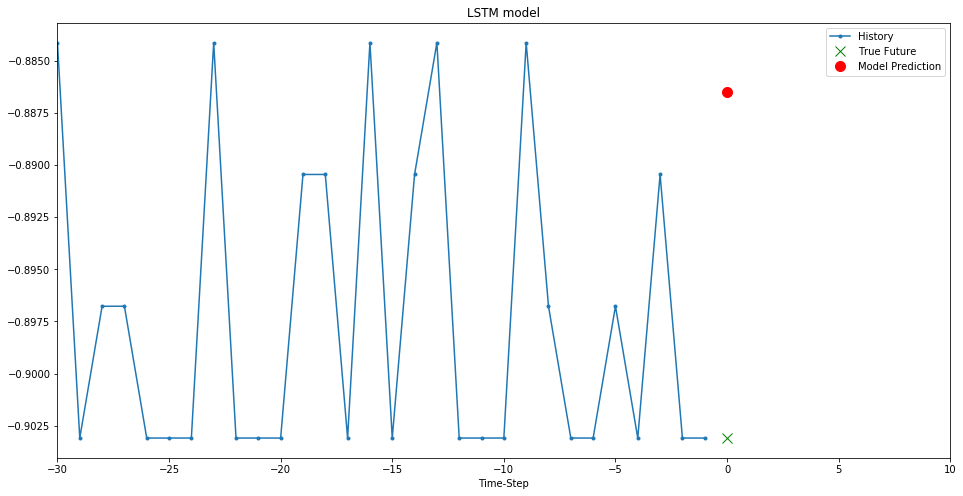

[[[-0.90309059]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89044997]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.88412966]]

 ...

 [[ 1.46702617]
  [ 1.46702617]
  [ 1.46702617]
  ...
  [ 1.47966679]
  [ 1.47966679]
  [ 1.4859871 ]]

 [[ 1.46702617]
  [ 1.46702617]
  [ 1.46070586]
  ...
  [ 1.47966679]
  [ 1.4859871 ]
  [ 1.4859871 ]]

 [[ 1.46702617]
  [ 1.46070586]
  [ 1.46070586]
  ...
  [ 1.4859871 ]
  [ 1.4859871 ]
  [ 1.4859871 ]]]
(30, 1)
()
[-0.8880106]


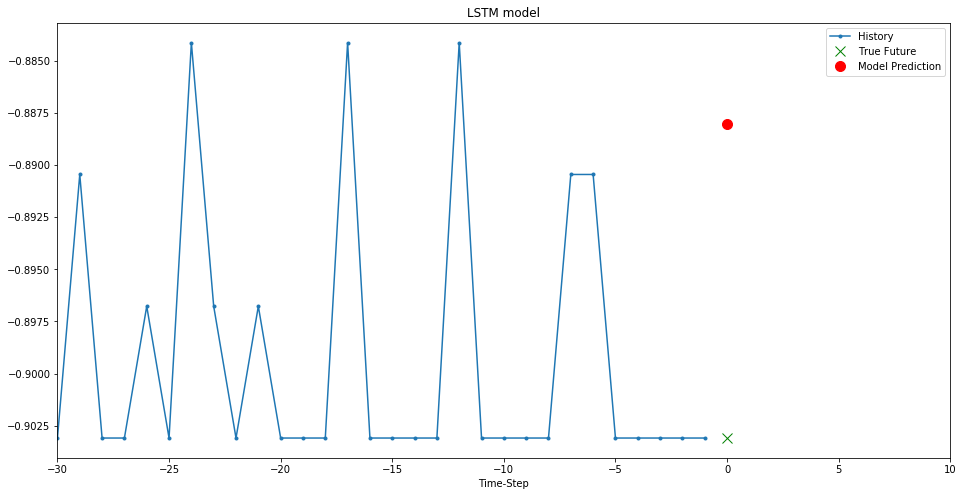

[[[1.46070586]
  [1.46070586]
  [1.46070586]
  ...
  [1.4859871 ]
  [1.4859871 ]
  [1.4859871 ]]

 [[1.46070586]
  [1.46070586]
  [1.46702617]
  ...
  [1.4859871 ]
  [1.4859871 ]
  [1.4859871 ]]

 [[1.46070586]
  [1.46702617]
  [1.46702617]
  ...
  [1.4859871 ]
  [1.4859871 ]
  [1.4859871 ]]

 ...

 [[1.32797932]
  [1.32797932]
  [1.32797932]
  ...
  [1.32797932]
  [1.32797932]
  [1.32165901]]

 [[1.32797932]
  [1.32797932]
  [1.32797932]
  ...
  [1.32797932]
  [1.32165901]
  [1.3153387 ]]

 [[1.32797932]
  [1.32797932]
  [1.32797932]
  ...
  [1.32165901]
  [1.3153387 ]
  [1.3153387 ]]]
(30, 1)
()
[1.4929489]


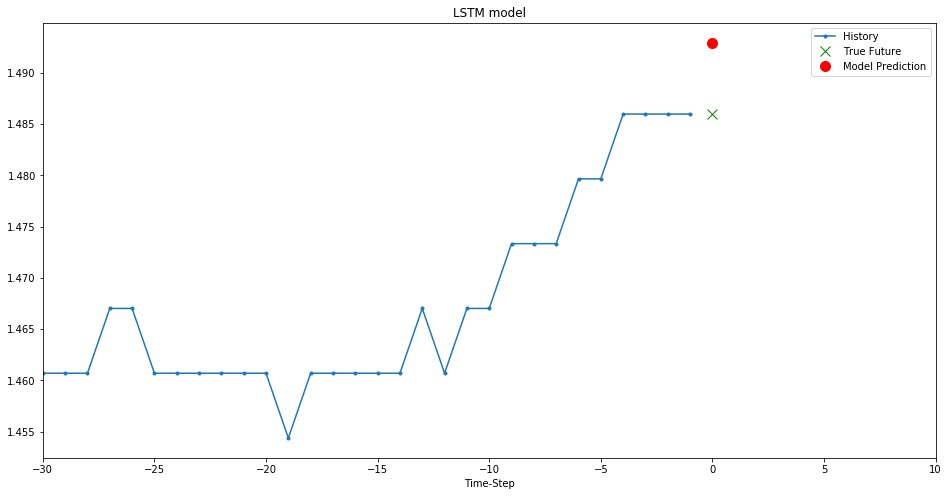

[[[ 1.32797932]
  [ 1.32797932]
  [ 1.32797932]
  ...
  [ 1.3153387 ]
  [ 1.3153387 ]
  [ 1.3153387 ]]

 [[ 1.32797932]
  [ 1.32797932]
  [ 1.32797932]
  ...
  [ 1.3153387 ]
  [ 1.3153387 ]
  [ 1.3153387 ]]

 [[ 1.32797932]
  [ 1.32797932]
  [ 1.32797932]
  ...
  [ 1.3153387 ]
  [ 1.3153387 ]
  [ 1.3153387 ]]

 ...

 [[-0.0751298 ]
  [-0.11937198]
  [-0.11305167]
  ...
  [-0.51123129]
  [-0.54915316]
  [-0.59339534]]

 [[-0.11937198]
  [-0.11305167]
  [-0.15097354]
  ...
  [-0.54915316]
  [-0.59339534]
  [-0.5744344 ]]

 [[-0.11305167]
  [-0.15097354]
  [-0.18889541]
  ...
  [-0.59339534]
  [-0.5744344 ]
  [-0.61867658]]]
(30, 1)
()
[1.3449118]


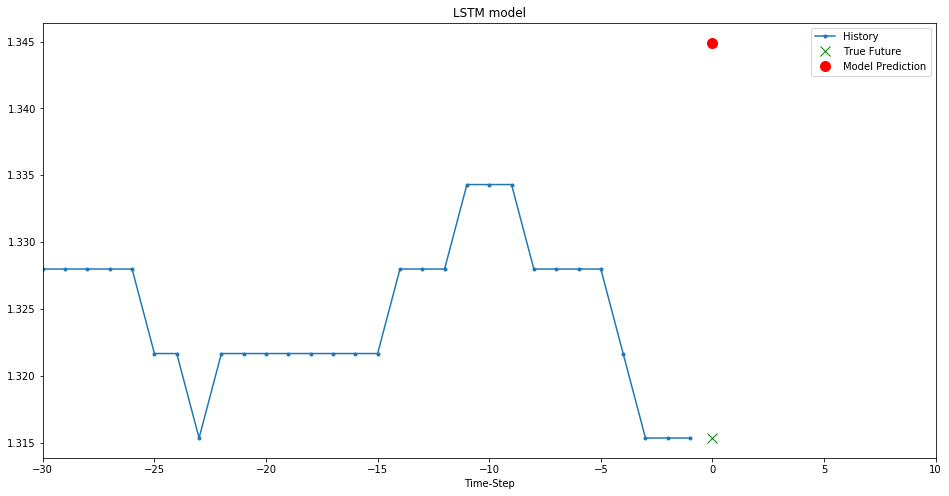

[[[-0.15097354]
  [-0.18889541]
  [-0.18889541]
  ...
  [-0.5744344 ]
  [-0.61867658]
  [-0.64395783]]

 [[-0.18889541]
  [-0.18889541]
  [-0.17625479]
  ...
  [-0.61867658]
  [-0.64395783]
  [-0.64395783]]

 [[-0.18889541]
  [-0.17625479]
  [-0.22049697]
  ...
  [-0.64395783]
  [-0.64395783]
  [-0.64395783]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.89677028]
  [-0.89677028]
  [-0.89044997]]

 [[-0.90309059]
  [-0.89044997]
  [-0.88412966]
  ...
  [-0.89677028]
  [-0.89044997]
  [-0.90309059]]

 [[-0.89044997]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]]
(30, 1)
()
[-0.5607493]


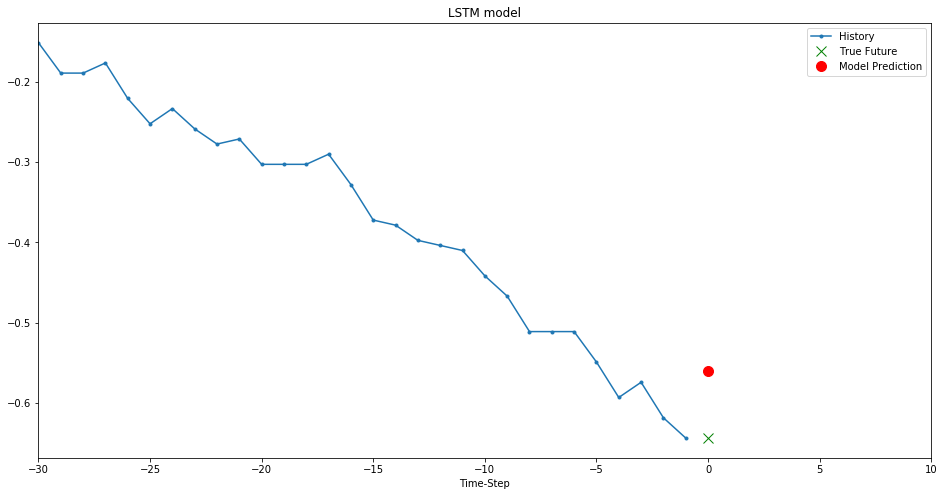

[[[-0.88412966]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.88412966]
  [-0.90309059]]

 [[-0.90309059]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.88412966]
  [-0.90309059]
  [-0.88412966]]

 [[-0.88412966]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.88412966]
  [-0.90309059]]]
(30, 1)
()
[-0.88698065]


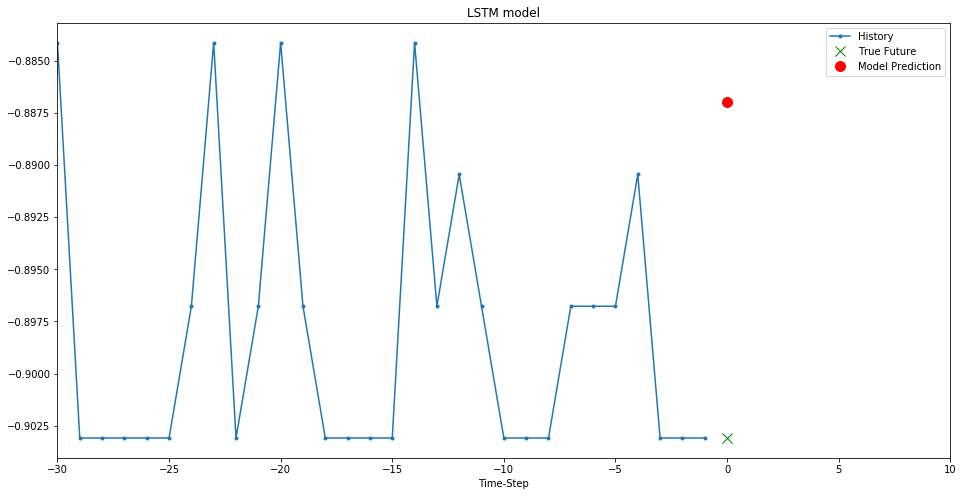

[[[-0.89044997]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 [[-0.90309059]
  [-0.89677028]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.88412966]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 [[-0.89044997]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.90309059]]]
(30, 1)
()
[-0.8853829]


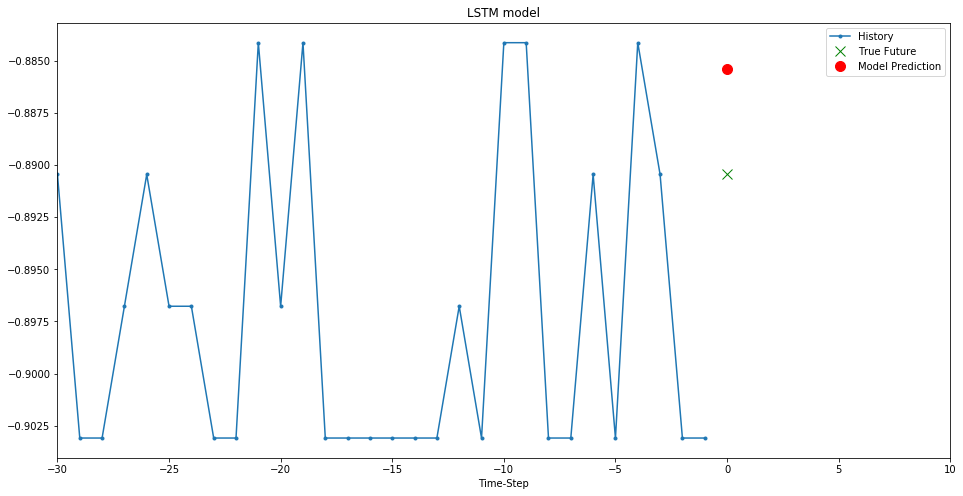

[[[-0.90309059]
  [-0.88412966]
  [-0.89677028]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.88412966]
  [-0.89677028]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89677028]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89677028]]

 ...

 [[-0.03088763]
  [-0.01192669]
  [ 0.01335455]
  ...
  [ 0.12712016]
  [ 0.15872172]
  [ 0.19032327]]

 [[-0.01192669]
  [ 0.01335455]
  [ 0.01335455]
  ...
  [ 0.15872172]
  [ 0.19032327]
  [ 0.2029639 ]]

 [[ 0.01335455]
  [ 0.01335455]
  [-0.01192669]
  ...
  [ 0.19032327]
  [ 0.2029639 ]
  [ 0.23456545]]]
(30, 1)
()
[-0.88803494]


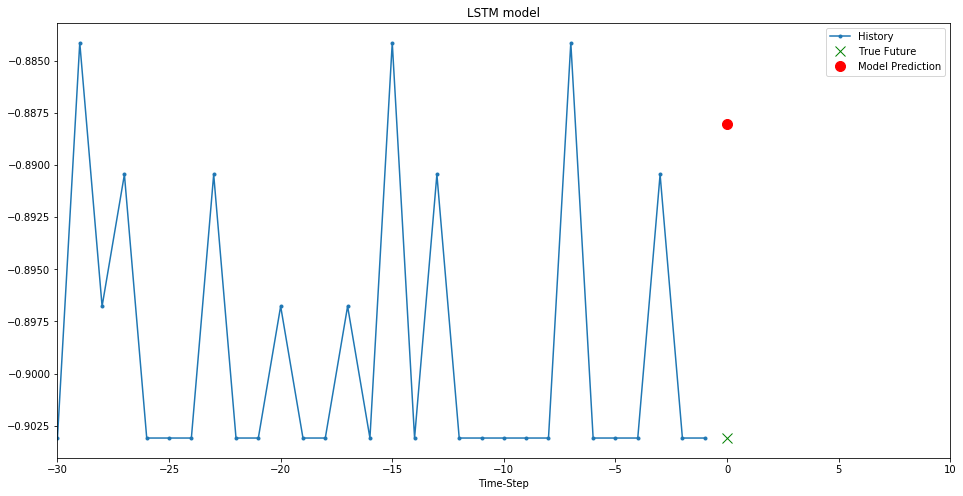

[[[ 0.01335455]
  [-0.01192669]
  [ 0.0386358 ]
  ...
  [ 0.2029639 ]
  [ 0.23456545]
  [ 0.29144825]]

 [[-0.01192669]
  [ 0.0386358 ]
  [ 0.0386358 ]
  ...
  [ 0.23456545]
  [ 0.29144825]
  [ 0.28512794]]

 [[ 0.0386358 ]
  [ 0.0386358 ]
  [ 0.06391705]
  ...
  [ 0.29144825]
  [ 0.28512794]
  [ 0.29144825]]

 ...

 [[ 0.9297997 ]
  [ 0.91715908]
  [ 0.91715908]
  ...
  [ 0.89187783]
  [ 0.91083877]
  [ 0.91715908]]

 [[ 0.91715908]
  [ 0.91715908]
  [ 0.91083877]
  ...
  [ 0.91083877]
  [ 0.91715908]
  [ 0.94244033]]

 [[ 0.91715908]
  [ 0.91083877]
  [ 0.90451846]
  ...
  [ 0.91715908]
  [ 0.94244033]
  [ 0.94244033]]]
(30, 1)
()
[0.22294238]


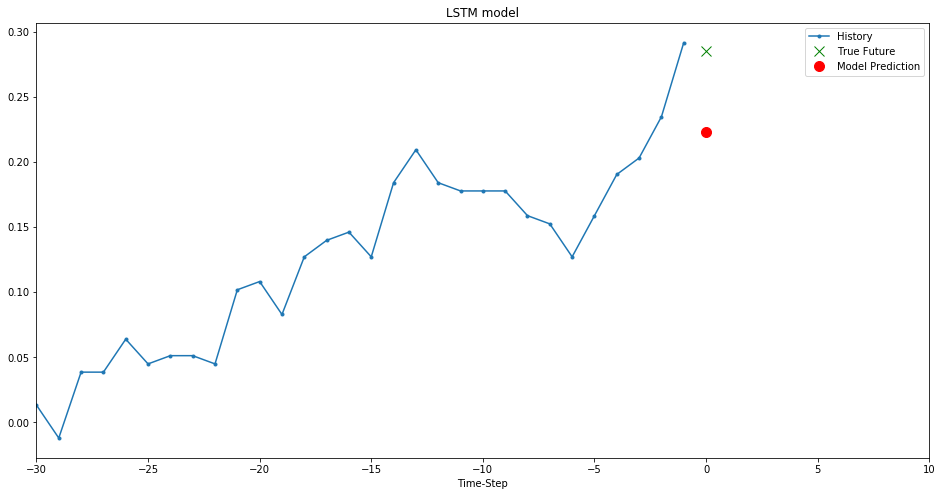

[[[0.91083877]
  [0.90451846]
  [0.90451846]
  ...
  [0.94244033]
  [0.94244033]
  [0.96140126]]

 [[0.90451846]
  [0.90451846]
  [0.90451846]
  ...
  [0.94244033]
  [0.96140126]
  [0.98668251]]

 [[0.90451846]
  [0.90451846]
  [0.90451846]
  ...
  [0.96140126]
  [0.98668251]
  [0.97404188]]

 ...

 [[1.22685434]
  [1.2078934 ]
  [1.16997154]
  ...
  [0.90451846]
  [0.91083877]
  [0.91083877]]

 [[1.2078934 ]
  [1.16997154]
  [1.16365122]
  ...
  [0.91083877]
  [0.91083877]
  [0.88555752]]

 [[1.16997154]
  [1.16365122]
  [1.16997154]
  ...
  [0.91083877]
  [0.88555752]
  [0.87923721]]]
(30, 1)
()
[0.9402013]


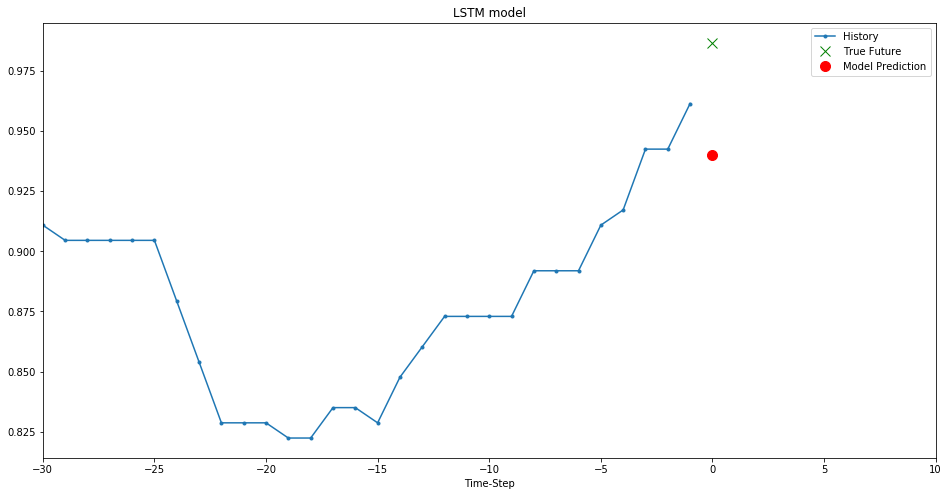

[[[ 1.16365122]
  [ 1.16997154]
  [ 1.16365122]
  ...
  [ 0.88555752]
  [ 0.87923721]
  [ 0.89819815]]

 [[ 1.16997154]
  [ 1.16365122]
  [ 1.13204967]
  ...
  [ 0.87923721]
  [ 0.89819815]
  [ 0.85395597]]

 [[ 1.16365122]
  [ 1.13204967]
  [ 1.13204967]
  ...
  [ 0.89819815]
  [ 0.85395597]
  [ 0.84131534]]

 ...

 [[-0.89044997]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89044997]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89044997]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]]
(30, 1)
()
[0.9325729]


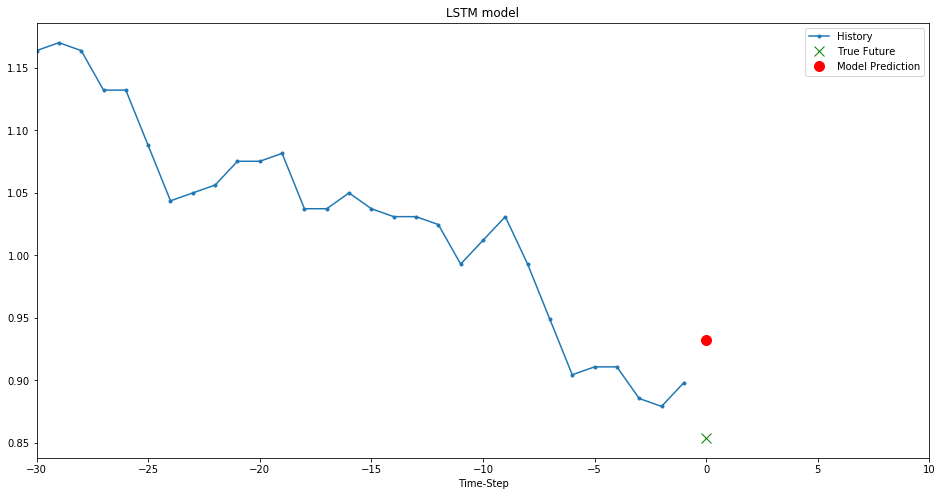

[[[-0.88412966]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.88412966]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.89677028]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.89677028]
  [-0.90309059]
  [-0.89044997]]

 [[-0.90309059]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.90309059]]]
(30, 1)
()
[-0.8893305]


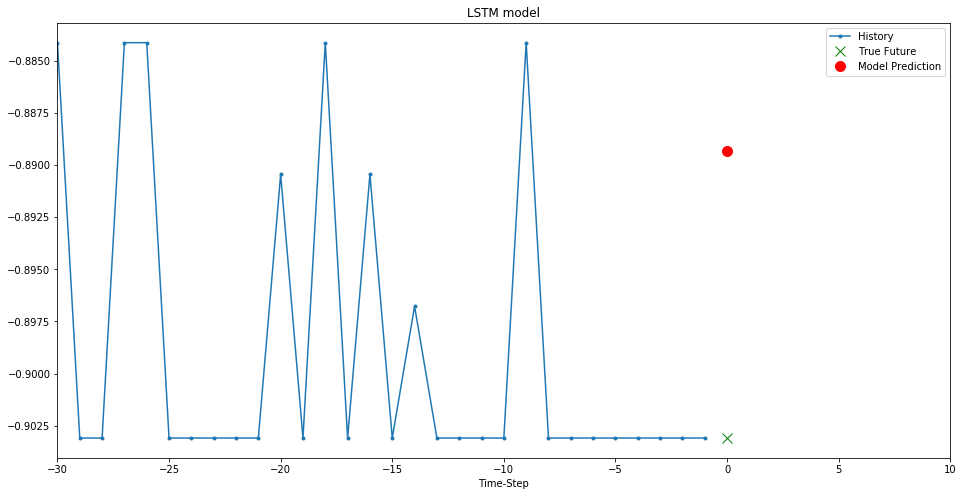

[[[-0.88412966]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89677028]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89677028]
  [-0.89677028]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 ...

 [[-0.88412966]
  [-0.89044997]
  [-0.89677028]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89044997]
  [-0.89677028]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89677028]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]]
(30, 1)
()
[-0.8864809]


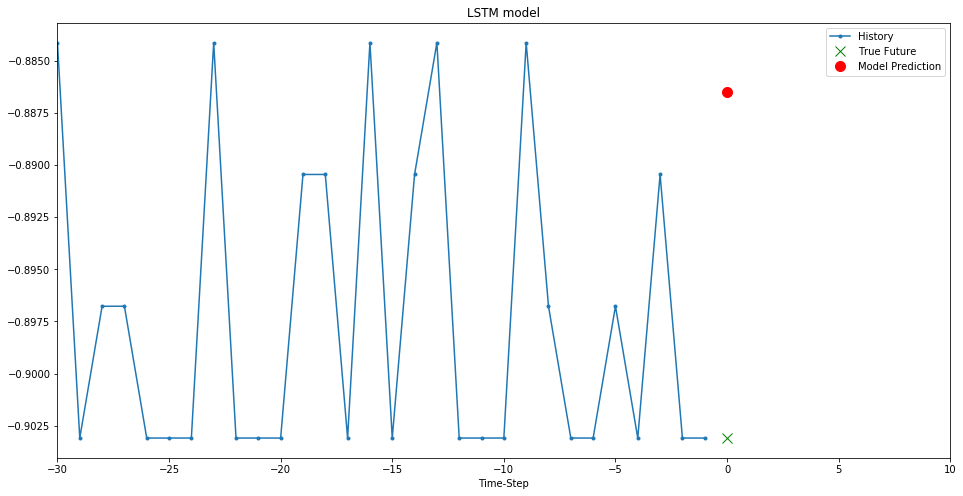

[[[-0.90309059]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.89044997]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.88412966]]

 ...

 [[ 1.46702617]
  [ 1.46702617]
  [ 1.46702617]
  ...
  [ 1.47966679]
  [ 1.47966679]
  [ 1.4859871 ]]

 [[ 1.46702617]
  [ 1.46702617]
  [ 1.46070586]
  ...
  [ 1.47966679]
  [ 1.4859871 ]
  [ 1.4859871 ]]

 [[ 1.46702617]
  [ 1.46070586]
  [ 1.46070586]
  ...
  [ 1.4859871 ]
  [ 1.4859871 ]
  [ 1.4859871 ]]]
(30, 1)
()
[-0.8880106]


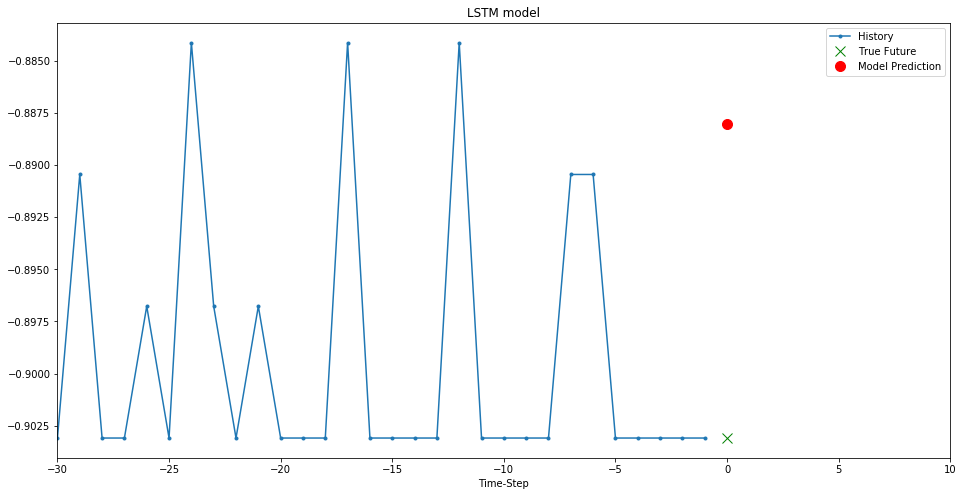

[[[1.46070586]
  [1.46070586]
  [1.46070586]
  ...
  [1.4859871 ]
  [1.4859871 ]
  [1.4859871 ]]

 [[1.46070586]
  [1.46070586]
  [1.46702617]
  ...
  [1.4859871 ]
  [1.4859871 ]
  [1.4859871 ]]

 [[1.46070586]
  [1.46702617]
  [1.46702617]
  ...
  [1.4859871 ]
  [1.4859871 ]
  [1.4859871 ]]

 ...

 [[1.32797932]
  [1.32797932]
  [1.32797932]
  ...
  [1.32797932]
  [1.32797932]
  [1.32165901]]

 [[1.32797932]
  [1.32797932]
  [1.32797932]
  ...
  [1.32797932]
  [1.32165901]
  [1.3153387 ]]

 [[1.32797932]
  [1.32797932]
  [1.32797932]
  ...
  [1.32165901]
  [1.3153387 ]
  [1.3153387 ]]]
(30, 1)
()
[1.4929489]


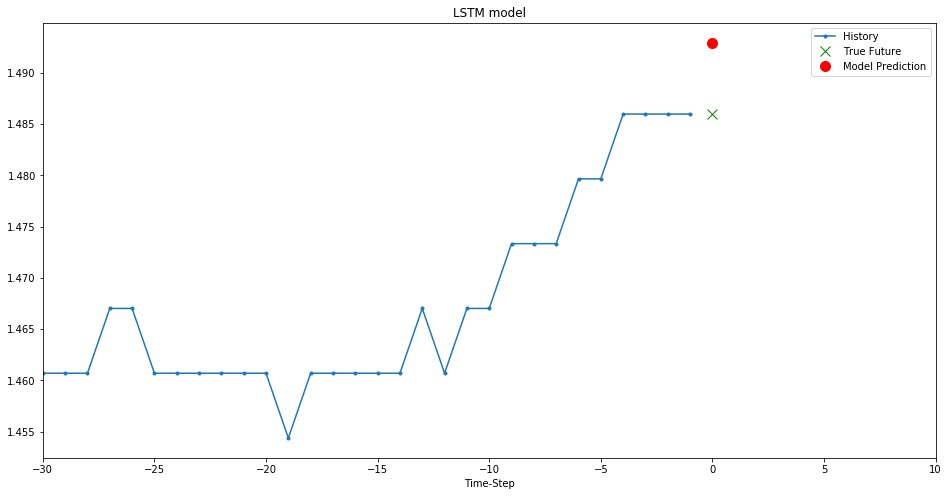

[[[ 1.32797932]
  [ 1.32797932]
  [ 1.32797932]
  ...
  [ 1.3153387 ]
  [ 1.3153387 ]
  [ 1.3153387 ]]

 [[ 1.32797932]
  [ 1.32797932]
  [ 1.32797932]
  ...
  [ 1.3153387 ]
  [ 1.3153387 ]
  [ 1.3153387 ]]

 [[ 1.32797932]
  [ 1.32797932]
  [ 1.32797932]
  ...
  [ 1.3153387 ]
  [ 1.3153387 ]
  [ 1.3153387 ]]

 ...

 [[-0.0751298 ]
  [-0.11937198]
  [-0.11305167]
  ...
  [-0.51123129]
  [-0.54915316]
  [-0.59339534]]

 [[-0.11937198]
  [-0.11305167]
  [-0.15097354]
  ...
  [-0.54915316]
  [-0.59339534]
  [-0.5744344 ]]

 [[-0.11305167]
  [-0.15097354]
  [-0.18889541]
  ...
  [-0.59339534]
  [-0.5744344 ]
  [-0.61867658]]]
(30, 1)
()
[1.3449118]


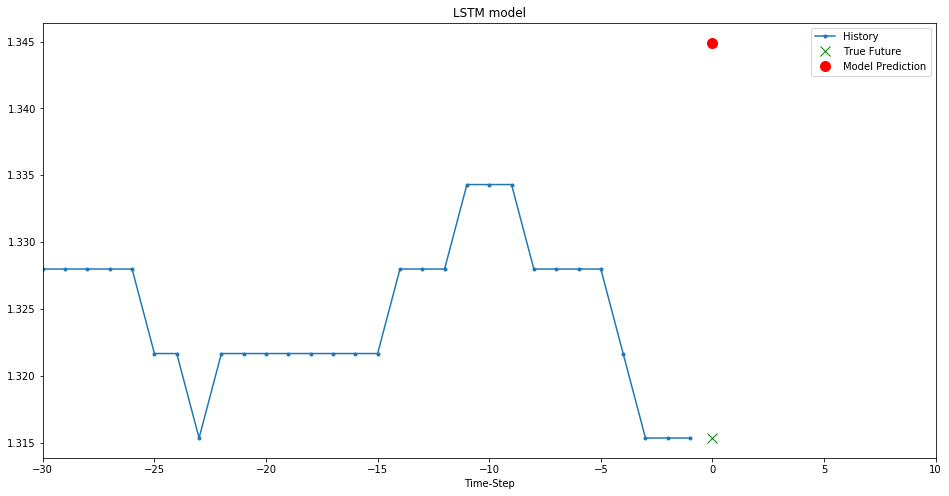

[[[-0.15097354]
  [-0.18889541]
  [-0.18889541]
  ...
  [-0.5744344 ]
  [-0.61867658]
  [-0.64395783]]

 [[-0.18889541]
  [-0.18889541]
  [-0.17625479]
  ...
  [-0.61867658]
  [-0.64395783]
  [-0.64395783]]

 [[-0.18889541]
  [-0.17625479]
  [-0.22049697]
  ...
  [-0.64395783]
  [-0.64395783]
  [-0.64395783]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.89677028]
  [-0.89677028]
  [-0.89044997]]

 [[-0.90309059]
  [-0.89044997]
  [-0.88412966]
  ...
  [-0.89677028]
  [-0.89044997]
  [-0.90309059]]

 [[-0.89044997]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]]
(30, 1)
()
[-0.5607493]


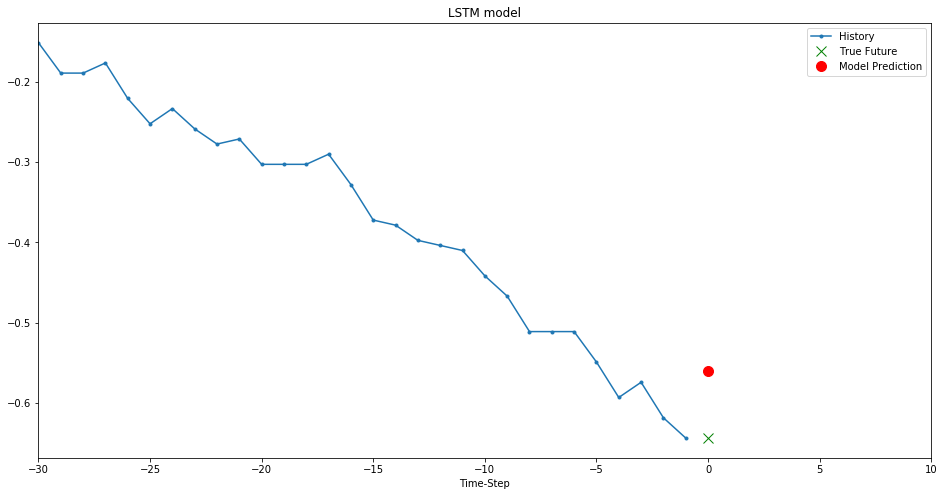

[[[-0.88412966]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.88412966]
  [-0.90309059]]

 [[-0.90309059]
  [-0.88412966]
  [-0.90309059]
  ...
  [-0.88412966]
  [-0.90309059]
  [-0.88412966]]

 [[-0.88412966]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.88412966]
  [-0.90309059]]]
(30, 1)
()
[-0.88698065]


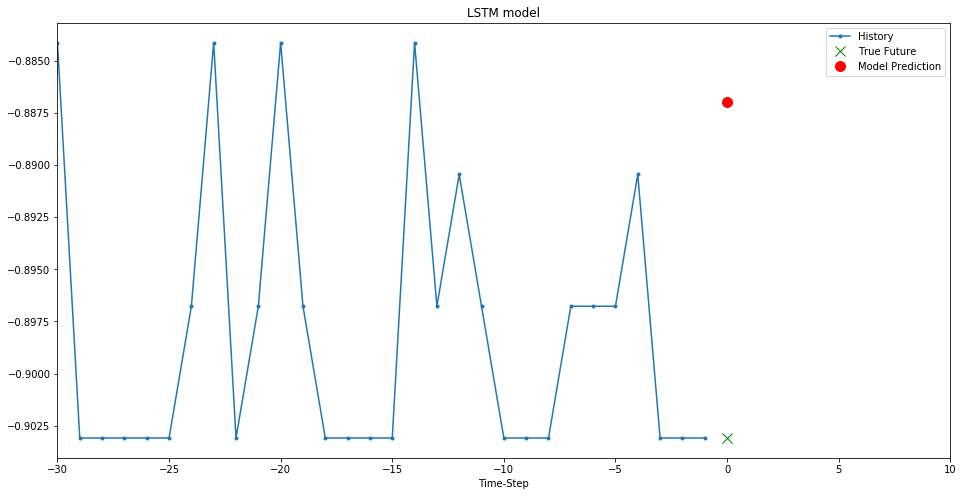

[[[-0.89044997]
  [-0.90309059]
  [-0.90309059]
  ...
  [-0.89044997]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.90309059]
  [-0.89677028]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 [[-0.90309059]
  [-0.89677028]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.88412966]]

 ...

 [[-0.90309059]
  [-0.90309059]
  [-0.89044997]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.90309059]]

 [[-0.90309059]
  [-0.89044997]
  [-0.90309059]
  ...
  [-0.90309059]
  [-0.90309059]
  [-0.89044997]]

 [[-0.89044997]
  [-0.90309059]
  [-0.88412966]
  ...
  [-0.90309059]
  [-0.89044997]
  [-0.90309059]]]
(30, 1)
()
[-0.8853829]


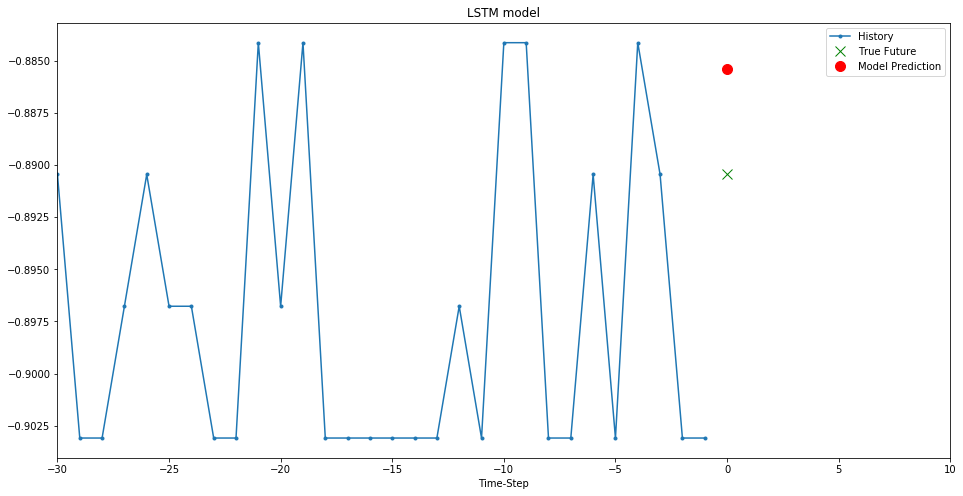

In [27]:
# lstm_model = simple_lstm_model
lstm_model = loaded_lstm_model

for x, y in val_univariate.take(25):
    print(x.numpy())
    print(x[0].numpy().shape)
    print(y[0].numpy().shape)
    pred = lstm_model.predict(x)[0]
    print(pred)
    plot = show_plot([x[0].numpy(), y[0].numpy(), lstm_model.predict(x)[0]], 0, 'LSTM model')
    plot.show()

# Calculate Mean Squared Errors

Simnple MSE calculation against a random selection of the validation data created earlier.

In [25]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# lstm_model = simple_lstm_model
lstm_model = loaded_lstm_model

real = []
predictions = []
for x, y in tqdm(val_univariate.take(250)):
    
    print(x.shape)
    
    # predicted value, scaled back up
    predictions.append(lstm_model.predict(x)[0][0] * uni_train_std + uni_train_mean)
    
    # real value, scaled back up
    real.append(y[0].numpy() * uni_train_std + uni_train_mean)

error = mean_squared_error(real, predictions)
print('Test MSE : %.9f' % error)

1it [00:00,  9.84it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


5it [00:00, 11.03it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


7it [00:00, 11.59it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


11it [00:00, 11.61it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)


13it [00:01, 12.62it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


17it [00:01, 12.52it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


19it [00:01, 12.76it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


23it [00:01, 12.58it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)
(256, 30, 1)


27it [00:02, 12.86it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


29it [00:02, 12.27it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


33it [00:02, 12.32it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


37it [00:02, 13.41it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


39it [00:03, 10.87it/s]

(256, 30, 1)
(256, 30, 1)


41it [00:03, 10.60it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


45it [00:03, 11.72it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


49it [00:03, 13.36it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


51it [00:04, 12.95it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


55it [00:04, 12.66it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


57it [00:04, 12.77it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


61it [00:04, 13.77it/s]

(34, 30, 1)
(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


65it [00:05, 13.33it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


67it [00:05, 12.93it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


71it [00:05, 12.70it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)
(256, 30, 1)


75it [00:05, 13.40it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


77it [00:06, 12.56it/s]

(256, 30, 1)
(256, 30, 1)


79it [00:06, 12.00it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


83it [00:06, 12.22it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)


85it [00:06, 13.54it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


89it [00:07, 12.87it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


91it [00:07, 12.82it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


95it [00:07, 13.07it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)
(256, 30, 1)


99it [00:07, 13.41it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


101it [00:07, 13.32it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


105it [00:08, 12.83it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


107it [00:08, 10.84it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)


111it [00:08, 12.44it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


113it [00:08, 12.47it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


117it [00:09, 12.93it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


121it [00:09, 14.32it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


123it [00:09, 12.76it/s]

(256, 30, 1)
(256, 30, 1)


125it [00:09, 11.90it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


129it [00:10, 11.93it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


133it [00:10, 13.00it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


135it [00:10, 13.08it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


139it [00:11, 12.74it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


141it [00:11, 11.99it/s]

(256, 30, 1)
(256, 30, 1)


145it [00:11,  8.62it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


147it [00:12,  9.62it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


151it [00:12, 10.62it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


153it [00:12, 10.51it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


157it [00:12, 11.47it/s]

(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


159it [00:13, 11.26it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


163it [00:13, 11.27it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


165it [00:13, 11.49it/s]

(256, 30, 1)
(256, 30, 1)


167it [00:13, 10.05it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)


171it [00:14, 11.27it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


173it [00:14, 11.42it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


177it [00:14, 12.45it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


181it [00:14, 13.96it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


183it [00:15, 12.55it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


187it [00:15, 12.42it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


189it [00:15, 12.60it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


193it [00:15, 14.11it/s]

(34, 30, 1)
(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


195it [00:15, 13.79it/s]

(256, 30, 1)
(256, 30, 1)


199it [00:16, 11.83it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


201it [00:16, 12.30it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


205it [00:16, 13.93it/s]

(34, 30, 1)
(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


209it [00:17, 13.45it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


211it [00:17, 12.62it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


215it [00:17, 13.03it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)
(256, 30, 1)


219it [00:17, 13.95it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


221it [00:17, 13.43it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


225it [00:18, 12.86it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


229it [00:18, 13.73it/s]

(256, 30, 1)
(34, 30, 1)
(256, 30, 1)
(256, 30, 1)


231it [00:18, 13.65it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


233it [00:18, 13.25it/s]

(256, 30, 1)
(256, 30, 1)


235it [00:19, 11.41it/s]

(256, 30, 1)
(256, 30, 1)


239it [00:19,  9.96it/s]

(256, 30, 1)
(256, 30, 1)
(34, 30, 1)


241it [00:19, 11.05it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


245it [00:20, 12.07it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


247it [00:20, 11.68it/s]

(256, 30, 1)
(256, 30, 1)
(256, 30, 1)


250it [00:20, 12.21it/s]

(256, 30, 1)
Test MSE : 43.985372008


# Scratch Area

In [ ]:
dataset = df
start_index = 0
end_index = 1440 * 3
history_size = 1440
target_size = 0

data = []
labels = []

start_index = start_index + history_size
if end_index is None:
    end_index = len(dataset) - target_size

for i in range(start_index, end_index):
    print('i', i)
    indices = range(i-history_size, i)
    print('indices', indices)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

np.array(data), np.array(labels)

In [ ]:
dataset['Time']